In [ ]:
from helper_functions import *
from classes import *
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
from fold_functions import *
from plot_functions import *
import sklearn.model_selection
import torch_directml 

: 

In [2]:
# Define the hyperparameters
DATA_DIR = 'data' # Path to the data directory
BATCH_SIZE = 32 # Batch size for the dataloaders
IN_CHANNELS = 3 # Number of input channels
HIDDEN_UNITS = 16  # Number of hidden units in the fully connected layer
NUM_CLASSES = 4 # Number of classes in the dataset
SIZE = 224 # Size of the images
LEARNING_RATE = 0.01 # Learning rate for the optimizer
EPOCHS = 20 # Number of epochs to train the model
GAMMA = 0.1 # Multiplicative factor of learning rate decay
STEP_SIZE = 15 # Step size for the learning rate scheduler
WEIGHT_DECAY = None # Weight decay for the optimizer
SEED = 1678737 # Seed for reproducibility
RANDOM_ROTATION = 10  # Random rotation for the images
NUM_FOLDS = 5 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the dictionary that hold the hyperparameters
hyperparameters = {
        'BATCH_SIZE': BATCH_SIZE,
        'IN_CHANNELS': IN_CHANNELS,
        'HIDDEN_UNITS': HIDDEN_UNITS,
        'NUM_CLASSES': NUM_CLASSES,
        'SIZE': SIZE,
        'LEARNING_RATE': LEARNING_RATE,
        'EPOCHS': EPOCHS,
        'GAMMA': GAMMA,
        'STEP_SIZE': STEP_SIZE,
        'WEIGHT_DECAY': WEIGHT_DECAY,
        'SEED': SEED,
        'RANDOM_ROTATION': RANDOM_ROTATION,
        'DEVICE': DEVICE
    }

In [3]:
# Define the transforms
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomRotation(RANDOM_ROTATION),
    transforms.ToTensor(),
])

# Define the classes
classes = {
    'no_tumor': 0,
    'meningioma_tumor': 1,
    'pituitary_tumor': 2,
    'glioma_tumor': 3
}

In [4]:
walk_through_dir(DATA_DIR)

# Pre-Process the dataset
combined_dir = combine_and_rename_images(DATA_DIR,classes)

walk_through_dir(combined_dir)
# Split the dataset into train, validation, and test sets

There are 2 directories and 0 images in 'data'.
There are 4 directories and 0 images in 'data/Testing'.
There are 0 directories and 74 images in 'data/Testing/pituitary_tumor'.
There are 0 directories and 105 images in 'data/Testing/no_tumor'.
There are 0 directories and 100 images in 'data/Testing/glioma_tumor'.
There are 0 directories and 115 images in 'data/Testing/meningioma_tumor'.
There are 4 directories and 0 images in 'data/Training'.
There are 0 directories and 827 images in 'data/Training/pituitary_tumor'.
There are 0 directories and 395 images in 'data/Training/no_tumor'.
There are 0 directories and 826 images in 'data/Training/glioma_tumor'.
There are 0 directories and 822 images in 'data/Training/meningioma_tumor'.


Combining and renaming images: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

Images combined and renamed successfully.
There are 0 directories and 3264 images in 'Combined'.


In [5]:
import numpy as np
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Load the data
dataset_data, dataset_labels = load_data('Combined', transform=transform)

# Remove the directory after loading data
shutil.rmtree('Combined')

# Define the target shape for resizing
target_shape = (224, 224)  # Width, Height

# Define a transform to resize images
resize_transform = transforms.Resize(target_shape)

# Preprocess dataset_data to ensure all images are resized and converted to numpy arrays
processed_data = []

for image in dataset_data:
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)

    # Resize the image using PIL if it is not a tensor
    if isinstance(image, Image.Image):
        resized_image = image.resize(target_shape)
        image_array = np.array(resized_image)  # Convert to NumPy array
    else:
        # If it's a PyTorch tensor, apply resize using transforms
        if image.dim() == 3:  # Assume tensor shape (C, H, W)
            # Convert to PIL Image
            image = transforms.ToPILImage()(image)
        resized_image = resize_transform(image)  # Apply the resize transformation
        image_array = np.array(resized_image)  # Convert to NumPy array

    processed_data.append(image_array)

# Convert the processed list to a NumPy array
dataset_data = np.array(processed_data)
dataset_labels = np.array(dataset_labels)

# Proceed with splitting the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    dataset_data, dataset_labels, test_size=0.1, random_state=42, stratify=dataset_labels
)


Loading images: 100%|██████████| 3264/3264 [00:10<00:00, 310.51it/s]


In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import torch
import torch.nn as nn
import torchvision.models as models

# Step 2: Define K-Fold Cross-Validation model evaluation on the training set
kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Placeholder to store fold results
fold_results = []

# K-Fold Cross Validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data, train_labels)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Step 3: Split the data into training and validation sets for this fold
    fold_train_data, fold_val_data = train_data[train_ids], train_data[val_ids]
    fold_train_labels, fold_val_labels = train_labels[train_ids], train_labels[val_ids]

    # Create dataloaders for the fold
    train_loader = DataLoader(CustomDataset(fold_train_data, fold_train_labels), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(CustomDataset(fold_val_data, fold_val_labels), batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    model = MRI_classification_CNN(IN_CHANNELS, HIDDEN_UNITS, NUM_CLASSES, SIZE, 0.2).to(DEVICE)

    # Define the optimizer, loss function, and scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    loss_fn = nn.CrossEntropyLoss()

    # Measure training time
    start = timer()

    # Train and validate the model
    results = train(model,
                    train_loader,
                    val_loader,
                    loss_fn,
                    optimizer,
                    EPOCHS,
                    DEVICE,
                    scheduler=scheduler,
                    early_stopping=False)  # Use early stopping if needed

    end = timer()
    fold_duration = end - start

    print(f'Fold {fold} finished in {fold_duration:.2f} seconds')

    # Save fold results (accuracy, loss, etc.)
    fold_results.append(results)

# Calculate the average metrics across all folds
average_accuracy = np.mean([result['accuracy'] for result in fold_results])
average_loss = np.mean([result['loss'] for result in fold_results])

print('Average accuracy across folds:', average_accuracy)
print('Average loss across folds:', average_loss)

# Step 4: Evaluate on the test set
test_loader = DataLoader(CustomDataset(test_data, test_labels), batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model on the test set
eval_res = evaluate(model, test_loader, loss_fn, DEVICE)

# Print evaluation results
print('Test set evaluation results:', eval_res)



FOLD 0
--------------------------------


[Epoch 1/20] Training:   0%|          | 0/74 [00:00<?, ?it/s]


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
from datetime import timedelta

# Assuming 'end' and 'start' are defined timestamps
elapsed_time = end - start
formatted_time = str(timedelta(seconds=elapsed_time))

print(f'Training time: {formatted_time}')

Training time: 10:16:08.909645


Normalized confusion matrix


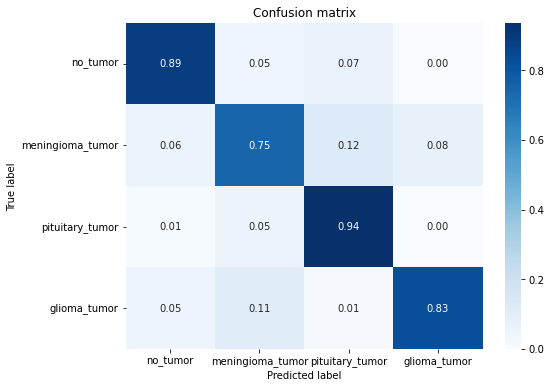

In [ ]:
import numpy as np

# Assuming eval_res is the evaluation results returned by the evaluate function
y_true = eval_res['all_targets']
y_pred_continuous = eval_res['all_preds']

# Convert continuous predictions to discrete class labels
y_pred = np.argmax(y_pred_continuous, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with sensitivity values
plot_confusion_matrix_with_sensitivity(cm, classes, normalize=True)

<Figure size 1080x504 with 0 Axes>

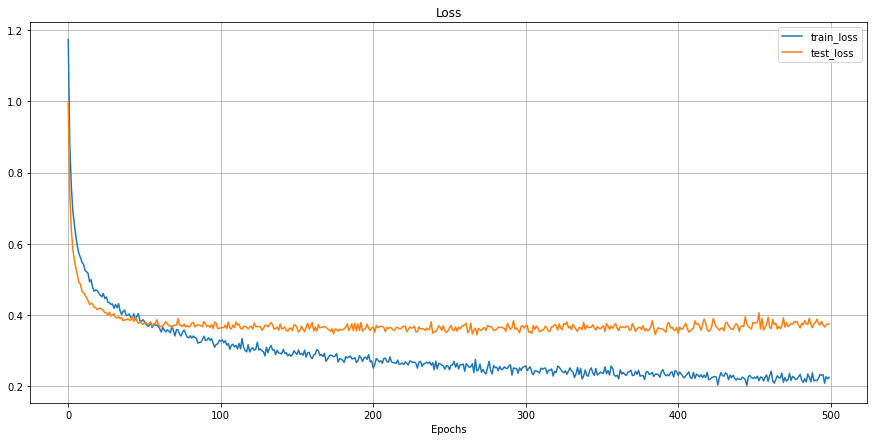

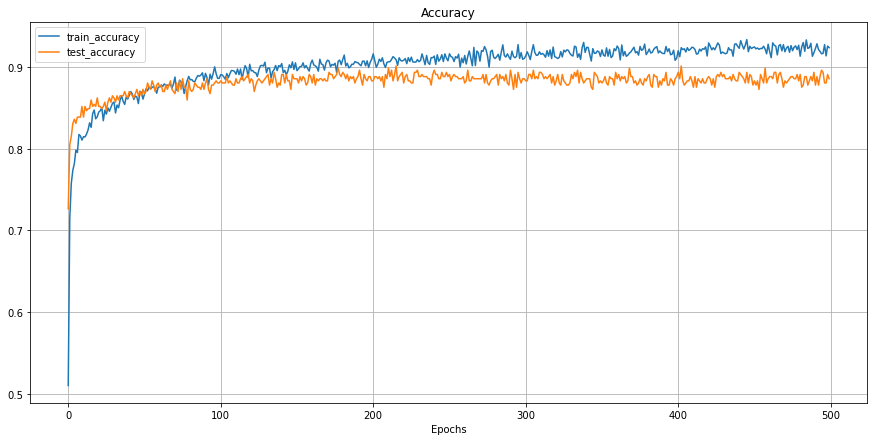

In [ ]:
# Plot loss and accuracy
plot_loss_curves(results)

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model, (IN_CHANNELS, SIZE, SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

all_preds shape: (327, 4)
all_labels shape: (327,)
Class no_tumor - AUC: 0.96, Precision: 0.78, Recall (Sensitivity): 0.89, F1 Score: 0.83
Class meningioma_tumor - AUC: 0.94, Precision: 0.83, Recall (Sensitivity): 0.75, F1 Score: 0.79
Class pituitary_tumor - AUC: 0.98, Precision: 0.84, Recall (Sensitivity): 0.94, F1 Score: 0.89
Class glioma_tumor - AUC: 0.95, Precision: 0.89, Recall (Sensitivity): 0.83, F1 Score: 0.86


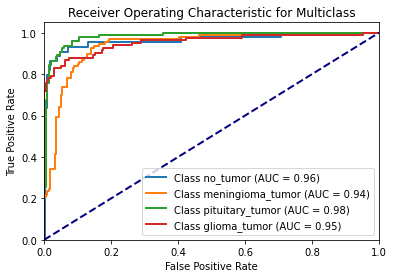

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, f1_score
import numpy as np

# Inverting the dictionary to map from indices to class names
idx_to_class = {v: k for k, v in classes.items()}

all_preds = eval_res['all_preds']
all_labels = eval_res['all_targets']

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f'all_preds shape: {all_preds.shape}')  # Should be (num_samples, NUM_CLASSES)
print(f'all_labels shape: {all_labels.shape}')  # Should be (num_samples,)

# Calculate ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds[:, i])
    roc_auc[i] = roc_auc_score(all_labels == i, all_preds[:, i])

# Calculate the sensitivity (recall) for each class
sensitivities = recall_score(all_labels, np.argmax(all_preds, axis=1), average=None)

# Calculate precision and F1 score for each class
precisions = precision_score(all_labels, np.argmax(all_preds, axis=1), average=None)
f1_scores = f1_score(all_labels, np.argmax(all_preds, axis=1), average=None)

# Printing the metrics with class names
for i in range(len(classes)):
    class_name = idx_to_class[i]
    print(f'Class {class_name} - AUC: {roc_auc[i]:.2f}, Precision: {precisions[i]:.2f}, '
          f'Recall (Sensitivity): {sensitivities[i]:.2f}, F1 Score: {f1_scores[i]:.2f}')

# Plotting the ROC curve for each class (optional)
import matplotlib.pyplot as plt

plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(idx_to_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()
